In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.optimize import curve_fit

# 1. Find Method of extracting any quantaties during flat top of shot

In [4]:
from helpers import get_variable,get_variable_pnbi,get_average,get_average_pnbi,plot2axis

In [5]:
datai = scipy.io.loadmat("data/nbi/NBI_initial.mat")

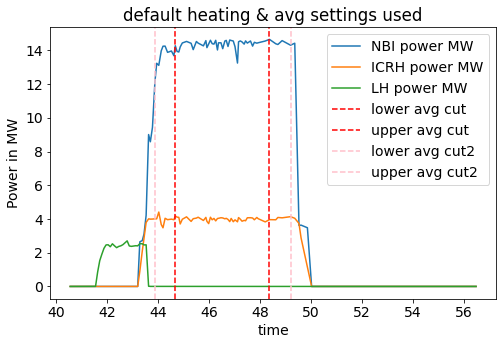

In [164]:
timei = get_variable(datai,'temps')
pnbii = get_variable_pnbi(datai)
Ipi = get_variable(datai,'ip')
picrhi = get_variable(datai,'picrh')
plhi = get_variable(datai,'plh')

cut1 = [50,100]
cut2 = [40,105]

plt.plot(timei,np.array(pnbii)*1e-6,label="NBI power MW")
#plt.plot(timei,Ipi,label="NBI power W")
plt.plot(timei,np.array(picrhi)*1e-6,label="ICRH power MW")
plt.plot(timei,np.array(plhi)*1e-6,label="LH power MW")
plt.axvline(x=timei[cut1[0]],color="red",ls="--",label="lower avg cut")
plt.axvline(x=timei[cut1[1]],color="red",ls="--",label="upper avg cut")
plt.axvline(x=timei[cut2[0]],color="pink",ls="--",label="lower avg cut2")
plt.axvline(x=timei[cut2[1]],color="pink",ls="--",label="upper avg cut2")
plt.xlabel("time")
plt.ylabel("Power in MW")
plt.title("default heating & avg settings used")
plt.legend(loc="best")
plt.savefig("plots/flattop.pdf")
plt.show()

Text(0.5, 1.0, 'default plasma current used')

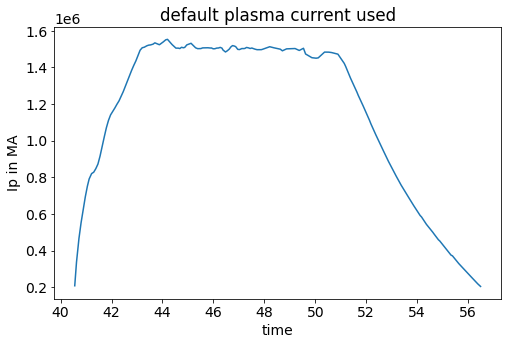

In [162]:
#plt.figsize((10,6))
plt.plot(timei,Ipi,label="NBI power W")
plt.xlabel("time")
plt.ylabel("Ip in MA")
plt.title("default plasma current used")

In [7]:
print("mean and std all in SI units")
print("nbi in W: ", get_average_pnbi(datai))
print("electron density: ", get_average(datai,'ne0'))
print("electron temperature: ", get_average(datai,'te0'))
print("energy confinement time: ", get_average(datai,'taue'))
print("pressure beta", get_average(datai,'betap'))

mean and std all in SI units
nbi in W:  (14372071.101488838, 238791.51852729448)
electron density:  (3.940424614580809e+19, 9.242047740330688e+17)
electron temperature:  (4813.907289701426, 50.30267068811559)
energy confinement time:  (0.1352145242992916, 0.0020946122369988112)
pressure beta (1.2353019050849219, 0.06071635534024018)


# 2. Extract for NBI 0-40MW

In [8]:
nbi_file_no = np.arange(0,29,1)

nbi_exp_ne = np.zeros((len(nbi_file_no),2))
nbi_exp_Te = np.zeros((len(nbi_file_no),2))
nbi_exp_tauE = np.zeros((len(nbi_file_no),2))
nbi_exp_beta = np.zeros((len(nbi_file_no),2))
nbi_exp_nbi = np.zeros((len(nbi_file_no),2))
nbi_exp_modeh = np.zeros((len(nbi_file_no),2))

for i in nbi_file_no:
    data = scipy.io.loadmat("data/nbi/"+str(i)+".mat")
    nbi_exp_nbi[i-1] = get_average_pnbi(data)
    nbi_exp_ne[i-1] = get_average(data,'ne0')
    nbi_exp_Te[i-1] = get_average(data,'te0')
    nbi_exp_tauE[i-1] = get_average(data,'taue')
    nbi_exp_beta[i-1] = get_average(data,'betap')
    nbi_exp_modeh[i-1] = get_average(data, 'modeh')

### make combined plot

In [148]:
def GoldstonScaling(x,c1,c2):
    return c1*x**(-0.5)+c2

def GoldstonScaling2(x,c1,c2,e):
    return c1*x**(e)+c2

def sort(x,y):
    p = np.argsort(x)
    x = x[p]
    y = y[p]
    return x,y

In [264]:
plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams.update({'font.size': 14})

In [101]:
def findLH2(nbi,modeh):
    p = np.argsort(nbi[:,0])
    nbi2 = nbi[:,0][p]
    modeh2 = modeh[:,0][p]
    startNotFound = True
    
    for i in range(len(nbi2)):
        if startNotFound:
            if modeh2[i] != 0:
                if i == 0:
                    LHstart = nbi2[0]
                    startNotFound = False
                else:
                    LHstart = nbi2[i-1]
                    startNotFound = False
        if modeh2[i] == 1.0:
            LHend = nbi2[i]
            break
    return LHstart,LHend

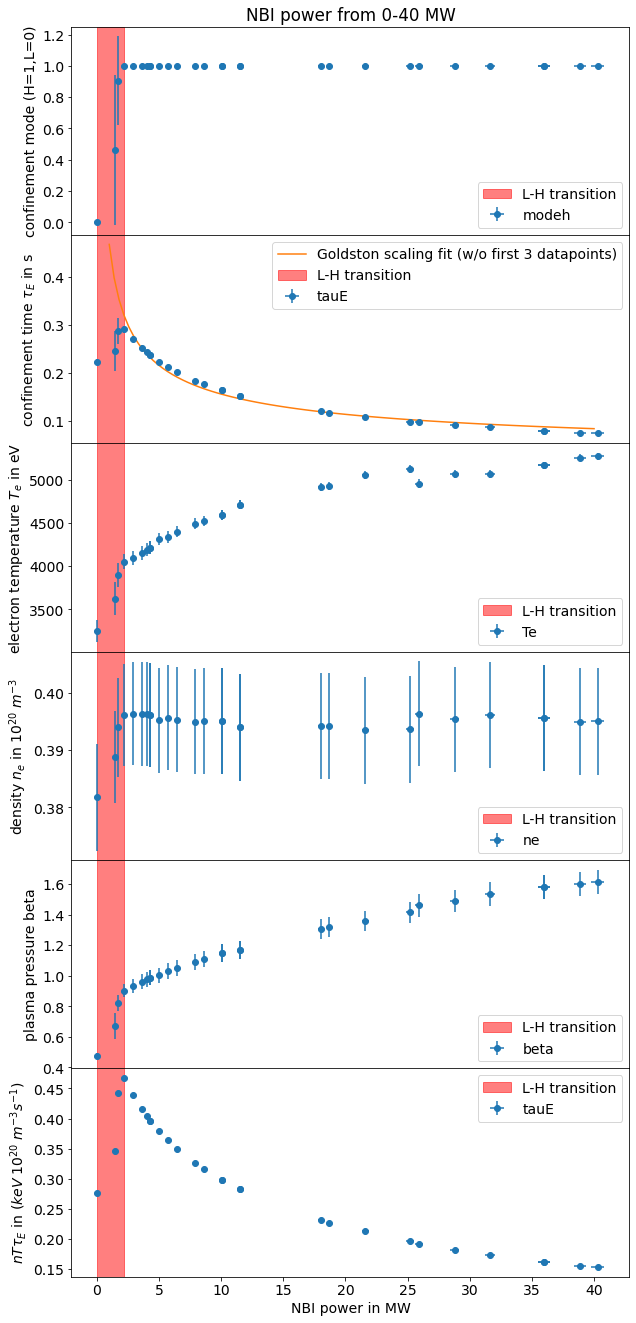

In [168]:
#bigplot
x = nbi_exp_nbi*1e-6
y1 = nbi_exp_modeh
y2 = nbi_exp_tauE
y3 = nbi_exp_Te
y4 = nbi_exp_ne*1e-20
y5 = nbi_exp_beta
y6 = nbi_exp_ne*1e-20*nbi_exp_Te*1e-3*nbi_exp_tauE
LH = findLH2(x,y1)

fig = plt.figure(figsize=(10,23))
gs = fig.add_gridspec(6, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

axs[0].errorbar(x[:,0],y1[:,0],xerr=x[:,1],yerr=y1[:,1],fmt='o',label="modeh")
axs[1].errorbar(x[:,0],y2[:,0],xerr=x[:,1],yerr=y2[:,1],fmt='o',label="tauE")
axs[1].plot(nbiii,GoldstonScaling(nbiii,poptGoldston[0],poptGoldston[1]),
         label="Goldston scaling fit (w/o first 3 datapoints)")
axs[2].errorbar(x[:,0],y3[:,0],xerr=x[:,1],yerr=y3[:,1],fmt='o',label="Te")
axs[3].errorbar(x[:,0],y4[:,0],xerr=x[:,1],yerr=y4[:,1],fmt='o',label="ne")
axs[4].errorbar(x[:,0],y5[:,0],xerr=x[:,1],yerr=y5[:,1],fmt='o',label="beta")
axs[5].errorbar(x[:,0],y6[:,0],xerr=x[:,1],yerr=y6[:,1],fmt='o',label="tauE")
axs[5].set_xlabel("NBI power in MW")
axs[0].set_title("NBI power from 0-40 MW")

ylabels = ["confinement mode (H=1,L=0)",r"confinement time $\tau_E$ in s",r"electron temperature $T_e$ in eV",
           r"density $n_e$ in $10^{20}\;m^{-3}$","plasma pressure beta",r"$nT\tau_E$ in $(keV\;10^{20}\;m^{-3}s^{-1})$"]
leglocs = ["lower right","upper right","lower right","lower right","lower right","upper right"]

for i in range(len(axs)):
    ax = axs[i]
    ax.axvspan(xmin=LH[0],xmax=LH[1],color="red",alpha=0.5,label="L-H transition")
    ax.label_outer()
    ax.legend(loc=leglocs[i])
    ax.set_ylabel(ylabels[i])
    
#plt.savefig("plots/NBIcombined.pdf")

In [104]:
max(triple[:,0])

4.107945837421794e+19

**Comment:** The triple product follows the general trend of the confinement time, i.e. peaks at ~4.68e19 keV/m^3/s and then decreases with increasing NBI power in H-mode. This is about two orders of magnitude lower than the ignition requirement of >5e21 keV/m^3/s (ref. Wesson, Tokamaks, 3ed.). <br>

Additional comments: <br>
electron density shows to increase signifantly before L-H transition and then stays roughly constant once in H-mode. Plasma beta which is proportional to pressure given our constant magnetic field, as well as temperature show to increase in H-mode, however with decreasing slope. <i>In general it can be noted that the most drastic changes happen during and before the transition to H-mode, just as expected. </i>

It can be seen that once in H-mode, the confinement time decreases with increasing Power even though H-mode is maintained. This is known as confinement degradation and the accepted scaling is given by the Goldston scaling [1]
given by $\tau_E \propto I_p P_{tot}^{-0.5}$ (The rest is major & minor radius and elongation, all geometrical and fixed here). Since $I_p \approx const.$ during flattop (see beginning figures), we can fit $\tau_E \propto c_1 P_{NBI}^{-0.5} + c_2$ where $c_2$ captures all the other power input. Fit shown in first graph and shows to agree well with trend of data (Note that first 3 datapoints of L-H transition have been omitted for fit).



[1] Robert J Goldston 1984 Plasma Phys. Control. Fusion 26 87, https://iopscience.iop.org/article/10.1088/0741-3335/26/1A/308/pdf

# 3. Access to H-mode
## 3.1 tau & triple product for varying B0,Ip and nbar
### 3.1.1 Varying toroidal field Bt

In [50]:
B0_file_no = ["0_9","0_25","0_50","0_60","0_75","0_80","1_1","1_25","1_50",
             "1_75","2_5","2_25","2_75","2","3"]

B0_exp_B0 = np.array([[0.9,0],[0.25,0],[0.5,0],[0.6,0],[0.75,0],[0.8,0],[1.1,0],
            [1.25,0],[1.5,0],[1.75,0],[2.5,0],[2.25,0],[2.75,0],[2,0],[3,0]])

B0_exp_ne = np.zeros((len(B0_file_no),2))
B0_exp_Te = np.zeros((len(B0_file_no),2))
B0_exp_tauE = np.zeros((len(B0_file_no),2))
B0_exp_modeh = np.zeros((len(B0_file_no),2))
B0_exp_q95 = np.zeros((len(B0_file_no),2)) #for section 3.3
B0_exp_q0 = np.zeros((len(B0_file_no),2)) #for section 3.3
B0_exp_qmin = np.zeros((len(B0_file_no),2)) #for section 3.3
B0_exp_qa = np.zeros((len(B0_file_no),2)) #for section 3.3

for i in range(len(B0_file_no)):
    data = scipy.io.loadmat("data/B0/"+B0_file_no[i]+".mat")
    B0_exp_ne[i] = get_average(data,'ne0')
    B0_exp_Te[i] = get_average(data,'te0')
    B0_exp_tauE[i] = get_average(data,'taue')
    B0_exp_modeh[i] = get_average(data, 'modeh')
    B0_exp_q95[i] = get_average(data,'q95')
    B0_exp_q0[i] = get_average(data, 'q0')
    B0_exp_qmin[i] = get_average(data,'qmin')
    B0_exp_qa[i] = get_average(data, 'qa')

In [231]:
def findHL2(nbi,modeh):
    p = np.argsort(nbi[:,0])
    nbi2 = nbi[:,0][p]
    modeh2 = modeh[:,0][p]
    startNotFound = True
    
    for i in range(len(nbi2)):
        if startNotFound:
            if modeh2[i] != 1:
                if i == 0:
                    LHstart = nbi2[0]
                    startNotFound = False
                else:
                    LHstart = nbi2[i-1]
                    startNotFound = False
        if modeh2[i] == 0:
            LHend = nbi2[i]
            break
    return LHstart,LHend

def linear(x,m,b):
    return m*x+b

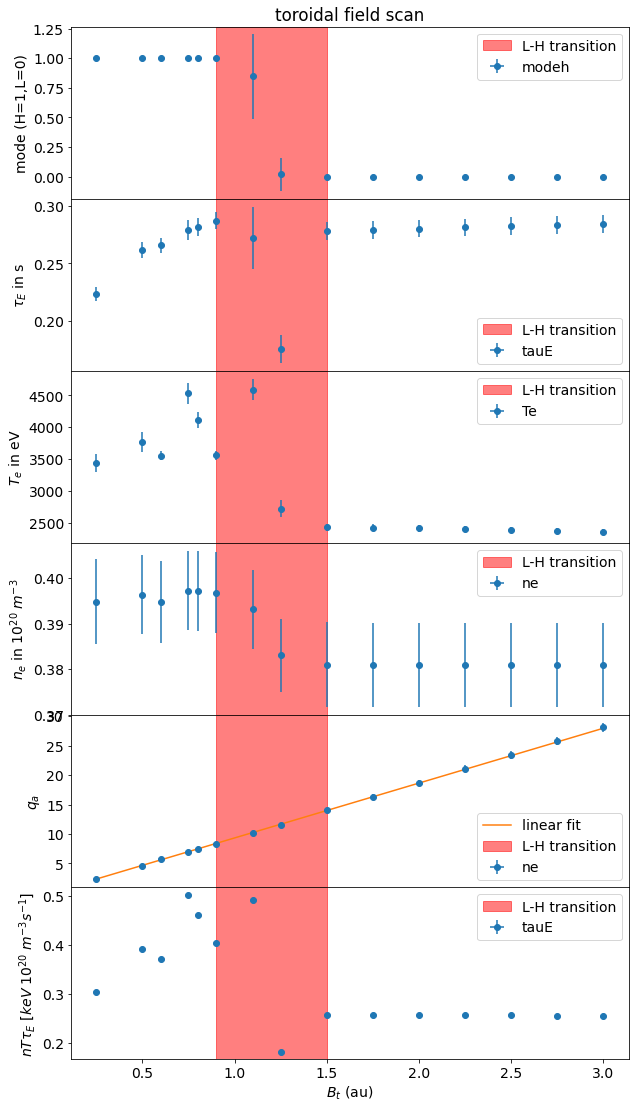

In [230]:
#bigplot
x = B0_exp_B0
y1 = B0_exp_modeh
y2 = B0_exp_tauE
y3 = B0_exp_Te
y4 = B0_exp_ne*1e-20
y5 = B0_exp_qa
y6 = B0_exp_ne*1e-20*B0_exp_Te*1e-3*B0_exp_tauE
LH = findHL2(x,y1)

fig = plt.figure(figsize=(10,19))
gs = fig.add_gridspec(6, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

popt, cov = curve_fit(linear,x[:,0],y5[:,0],sigma=y5[:,1])
xx = np.linspace(min(x[:,0]),max(x[:,0]),1000)

axs[0].errorbar(x[:,0],y1[:,0],xerr=x[:,1],yerr=y1[:,1],fmt='o',label="modeh")
axs[1].errorbar(x[:,0],y2[:,0],xerr=x[:,1],yerr=y2[:,1],fmt='o',label="tauE")
axs[2].errorbar(x[:,0],y3[:,0],xerr=x[:,1],yerr=y3[:,1],fmt='o',label="Te")
axs[3].errorbar(x[:,0],y4[:,0],xerr=x[:,1],yerr=y4[:,1],fmt='o',label="ne")
axs[4].errorbar(x[:,0],y5[:,0],xerr=x[:,1],yerr=y5[:,1],fmt='o',label="ne")
axs[4].plot(xx,linear(xx,popt[0],popt[1]),label="linear fit")
axs[5].errorbar(x[:,0],y6[:,0],xerr=x[:,1],yerr=y6[:,1],fmt='o',label="tauE")
axs[5].set_xlabel(r"$B_t$ (au)")
axs[0].set_title(r"toroidal field scan")

ylabels = ["mode (H=1,L=0)",r"$\tau_E$ in s",r"$T_e$ in eV",
           r"$n_e$ in $10^{20}\;m^{-3}$",r"$q_a$",r"$nT\tau_E$ [$keV\;10^{20}\;m^{-3}s^{-1}$]"]
leglocs = ["upper right","lower right","upper right","upper right","lower right","upper right"]

for i in range(len(axs)):
    ax = axs[i]
    ax.axvspan(xmin=LH[0],xmax=LH[1],color="red",alpha=0.5,label="L-H transition")
    ax.label_outer()
    ax.legend(loc=leglocs[i])
    ax.set_ylabel(ylabels[i])
    
plt.savefig("plots/BtCombined.pdf")

In [265]:
np.min(B0_exp_qa,axis=0)

array([2.36013331, 0.0685146 ])

**Comment:** The triple product increases in H-mode with increasing B. At some critical Bt the plasma goes into L-mode and stays in L-mode with increasing B. We shall see later that this caused by the fact that L-H transition threshold increases in B, hence the threshold is not reached for higher B due to constant heating power. In the graphs of n,T and tauE we see that it is mostly the temperature and the density that drop, not the confinement time. 

### 3.1.2 Varying plasma current Ip

In [55]:
Ip_file_no = np.arange(0,12,1)

Ip_exp_Ip = np.zeros((len(Ip_file_no),2))
Ip_exp_ne = np.zeros((len(Ip_file_no),2))
Ip_exp_Te = np.zeros((len(Ip_file_no),2))
Ip_exp_tauE = np.zeros((len(Ip_file_no),2))
Ip_exp_modeh = np.zeros((len(Ip_file_no),2))
Ip_exp_q95 = np.zeros((len(Ip_file_no),2)) #for section 3.3
Ip_exp_q0 = np.zeros((len(Ip_file_no),2)) #for section 3.3
Ip_exp_qmin = np.zeros((len(Ip_file_no),2)) #for section 3.3
Ip_exp_qa = np.zeros((len(Ip_file_no),2)) #for section 3.3

for i in Ip_file_no:
    data = scipy.io.loadmat("data/Ip/"+str(i)+".mat")
    Ip_exp_Ip[i] = get_average(data,'ip')
    Ip_exp_ne[i] = get_average(data,'ne0')
    Ip_exp_Te[i] = get_average(data,'te0')
    Ip_exp_tauE[i] = get_average(data,'taue')
    Ip_exp_modeh[i] = get_average(data, 'modeh')
    Ip_exp_q95[i] = get_average(data,'q95')
    Ip_exp_q0[i] = get_average(data, 'q0')
    Ip_exp_qmin[i] = get_average(data,'qmin')
    Ip_exp_qa[i] = get_average(data, 'qa')

In [236]:
def OneOverX(x,a):
    return (a/x)

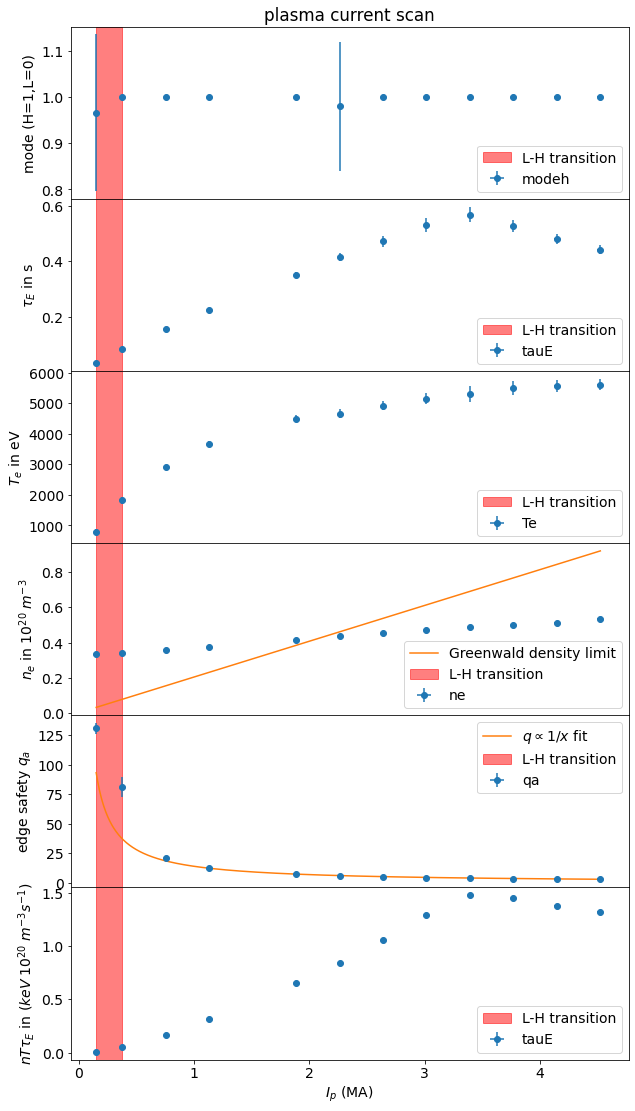

In [237]:
#bigplot
x = Ip_exp_Ip*1e-6 #MA
y1 = Ip_exp_modeh
y2 = Ip_exp_tauE
y3 = Ip_exp_Te
y4 = Ip_exp_ne*1e-20
y5 = Ip_exp_qa
y6 = Ip_exp_ne*1e-20*Ip_exp_Te*1e-3*Ip_exp_tauE
LH = findLH2(x,y1)

fig = plt.figure(figsize=(10,19))
gs = fig.add_gridspec(6, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

popt, cov = curve_fit(OneOverX,x[:,0],y5[:,0],sigma=y5[:,1])
xx = np.linspace(min(x[:,0]),max(x[:,0]),1000)


a = 1.25 #m for JET
Ipp = np.linspace(min(x[:,0]),max(x[:,0]),100)
nG = Ipp/(np.pi*a**2) #comes out in n20


axs[0].errorbar(x[:,0],y1[:,0],xerr=x[:,1],yerr=y1[:,1],fmt='o',label="modeh")
axs[1].errorbar(x[:,0],y2[:,0],xerr=x[:,1],yerr=y2[:,1],fmt='o',label="tauE")
axs[2].errorbar(x[:,0],y3[:,0],xerr=x[:,1],yerr=y3[:,1],fmt='o',label="Te")
axs[3].errorbar(x[:,0],y4[:,0],xerr=x[:,1],yerr=y4[:,1],fmt='o',label="ne")
axs[3].plot(Ipp,nG,label="Greenwald density limit")
axs[4].errorbar(x[:,0],y5[:,0],xerr=x[:,1],yerr=y5[:,1],fmt='o',label="qa")
axs[4].plot(xx,OneOverX(xx,popt[0]),label=r"$q \propto 1/x$ fit")
axs[5].errorbar(x[:,0],y6[:,0],xerr=x[:,1],yerr=y6[:,1],fmt='o',label="tauE")
axs[5].set_xlabel(r"$I_p$ (MA)")
axs[0].set_title(r"plasma current scan")

ylabels = ["mode (H=1,L=0)",r"$\tau_E$ in s",r"$T_e$ in eV",
           r"$n_e$ in $10^{20}\;m^{-3}$",r"edge safety $q_a$",r"$nT\tau_E$ in $(keV\;10^{20}\;m^{-3}s^{-1})$"]
leglocs = ["lower right","lower right","lower right","lower right","upper right","lower right"]

for i in range(len(axs)):
    ax = axs[i]
    ax.axvspan(xmin=LH[0],xmax=LH[1],color="red",alpha=0.5,label="L-H transition")
    ax.label_outer()
    ax.legend(loc=leglocs[i])
    ax.set_ylabel(ylabels[i])
    
plt.savefig("plots/IpCombined.pdf")

In [266]:
np.min(Ip_exp_qa,axis=0)

array([2.95884148, 0.08644833])

In [235]:
Ip_exp_Ip[-4]*1e-6

array([3.39265336, 0.01987558])

**Comment:** The measurements here only capture H-mode behaviour. The triple product shows to increase with increasing plasma current in H-mode up to some critical current $I_{p,max} \sim 3.2$ MA, after which the triple product drops again. Plots of n,T and tau show that this behaviour of the triple product is caused by a peak in confinement time.

### 3.1.3 Varying avg density nbar

In [60]:
nbar_file_no = np.arange(0,12,1)

nbar_exp_nbar = np.zeros((len(Ip_file_no),2))
nbar_exp_ne = np.zeros((len(Ip_file_no),2))
nbar_exp_Te = np.zeros((len(Ip_file_no),2))
nbar_exp_tauE = np.zeros((len(Ip_file_no),2))
nbar_exp_modeh = np.zeros((len(Ip_file_no),2))
nbar_exp_beta = np.zeros((len(Ip_file_no),2))

for i in nbar_file_no:
    data = scipy.io.loadmat("data/nbar/"+str(i)+".mat")
    nbar_exp_nbar[i] = get_average(data,'nbar')
    nbar_exp_ne[i] = get_average(data,'ne0')
    nbar_exp_Te[i] = get_average(data,'te0')
    nbar_exp_tauE[i] = get_average(data,'taue')
    nbar_exp_modeh[i] = get_average(data, 'modeh')
    nbar_exp_beta[i] = get_average(data, 'betap')

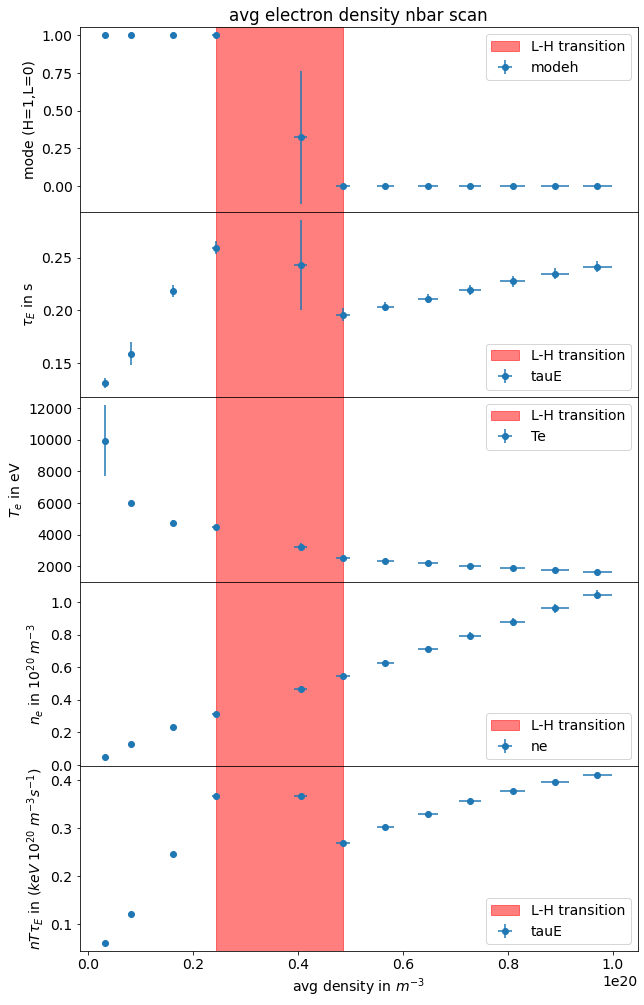

In [222]:
#bigplot
x = nbar_exp_nbar
y1 = nbar_exp_modeh
y2 = nbar_exp_tauE
y3 = nbar_exp_Te
y4 = nbar_exp_ne*1e-20
y5 = nbar_exp_ne*1e-20*nbar_exp_Te*1e-3*nbar_exp_tauE
LH = findHL2(x,y1)

fig = plt.figure(figsize=(10,17))
gs = fig.add_gridspec(5, hspace=0)
axs = gs.subplots(sharex=True, sharey=False)

axs[0].errorbar(x[:,0],y1[:,0],xerr=x[:,1],yerr=y1[:,1],fmt='o',label="modeh")
axs[1].errorbar(x[:,0],y2[:,0],xerr=x[:,1],yerr=y2[:,1],fmt='o',label="tauE")
axs[2].errorbar(x[:,0],y3[:,0],xerr=x[:,1],yerr=y3[:,1],fmt='o',label="Te")
axs[3].errorbar(x[:,0],y4[:,0],xerr=x[:,1],yerr=y4[:,1],fmt='o',label="ne")
axs[4].errorbar(x[:,0],y5[:,0],xerr=x[:,1],yerr=y5[:,1],fmt='o',label="tauE")
axs[4].set_xlabel(r"avg density in $m^{-3}$")
axs[0].set_title(r"avg electron density nbar scan")

ylabels = ["mode (H=1,L=0)",r"$\tau_E$ in s",r"$T_e$ in eV",
           r"$n_e$ in $10^{20}\;m^{-3}$",r"$nT\tau_E$ in $(keV\;10^{20}\;m^{-3}s^{-1})$"]
leglocs = ["upper right","lower right","upper right","lower right","lower right"]

for i in range(len(axs)):
    ax = axs[i]
    ax.axvspan(xmin=LH[0],xmax=LH[1],color="red",alpha=0.5,label="L-H transition")
    ax.label_outer()
    ax.legend(loc=leglocs[i])
    ax.set_ylabel(ylabels[i])
    
plt.savefig("plots/nbarCombined.pdf")

**Comment:** The triple product increases with density in H-mode, then drops as the plamsa is in L-mode with increasing density. We will show later that this due to higher threshold with increasing denisty and heating is constant here. In L-mode, the triple product also increases with increasing density. Looking at the individual plots shows that this behaviour is mostly caused by confinement time.

## 3.2 LtoH power transition threshold dependence on B0 and nbar
### 3.2.1 LtoH vs B0

In [65]:
LH_file_B0 = [np.arange(0,10,1),np.arange(0,12,1),np.arange(0,12,1),
              np.arange(0,13,1),np.arange(0,13,1)]
LH_file_folders = ["B0_1_2","B0_1_5","B0_2","B0_2_5","B0_4"]

LH_exp_nbi = [np.zeros((10,2)),np.zeros((12,2)),np.zeros((12,2)),
              np.zeros((13,2)),np.zeros((13,2))]
LH_exp_modeh = [np.zeros((10,2)),np.zeros((12,2)),np.zeros((12,2)),
              np.zeros((13,2)),np.zeros((13,2))]

for i,j in zip(range(len(LH_file_B0)),LH_file_folders):
    for k in range(len(LH_file_B0[i])):
        data = scipy.io.loadmat("data/LtoH/B0/"+j+"/"+str(k)+".mat")
        LH_exp_nbi[i][k] = get_average_pnbi(data)
        LH_exp_modeh[i][k] = get_average(data, 'modeh')

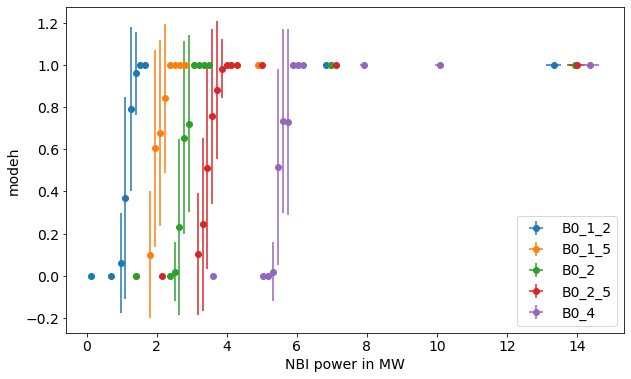

In [250]:
plt.figure(figsize=(10,6))
for i in range(len(LH_file_folders)):
    plt.errorbar(LH_exp_nbi[i][:,0]*1e-6,LH_exp_modeh[i][:,0],
                 LH_exp_modeh[i][:,1],LH_exp_nbi[i][:,1]*1e-6,
                 fmt='o',label=LH_file_folders[i])
plt.xlabel("NBI power in MW")
plt.ylabel("modeh")
plt.legend(loc="best")
plt.savefig("plots/PLHvsBtMethod.pdf")
plt.show()

In [67]:
def findLH(nbi,modeh):
    p = np.argsort(nbi[:,0])
    nbi2 = nbi[:,0][p]
    modeh2 = modeh[:,0][p]
    
    for i in range(len(nbi2)):
        if modeh2[i] == 1.0:
            LH_std = (nbi2[i+1]-nbi2[i-1])/2
            LH = [nbi2[i],LH_std]
            break
    return LH

In [68]:
LHs = np.zeros((5,2))
for i in range(5):
    LHs[i] = findLH(LH_exp_nbi[i],LH_exp_modeh[i])

In [69]:
def powerLaw(x,a,c):
    return a*x**c

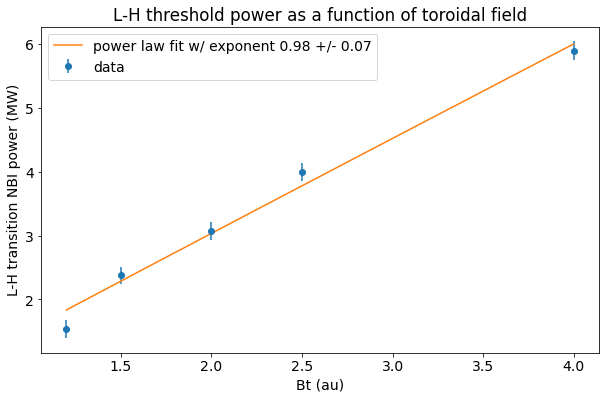

In [249]:
plt.figure(figsize=(10,6))
B0s = [1.2,1.5,2,2.5,4]
plt.errorbar(B0s,LHs[:,0]*1e-6,LHs[:,1]*1e-6,fmt='o',label="data")

popt,cov = curve_fit(powerLaw,B0s,LHs[:,0]*1e-6,sigma=LHs[:,1]*1e-6)
stds = np.sqrt(np.diag(cov))

x = np.linspace(1.2,4,1000)
plt.plot(x,powerLaw(x,popt[0],popt[1]),
         label="power law fit w/ exponent {:.2f} +/- {:.2f}".format(popt[1],stds[1]))

plt.xlabel("Bt (au)")
plt.ylabel("L-H transition NBI power (MW)")
plt.legend(loc="best")
plt.title("L-H threshold power as a function of toroidal field")
plt.savefig("plots/PLHscalingBt.pdf")
plt.show()

### 3.2.1 LtoH vs nbar

In [71]:
LH2_file_nbar = np.arange(0,49,1)
LH2_exp_nbar = np.zeros((49,2))
LH2_exp_nbi = np.zeros((49,2))
LH2_exp_modeh = np.zeros((49,2))

for k in LH2_file_nbar:
    data = scipy.io.loadmat("data/LtoH/nbar/"+str(k)+".mat")
    LH2_exp_nbi[k] = get_average_pnbi(data)
    LH2_exp_modeh[k] = get_average(data, 'modeh')
    LH2_exp_nbar[k] = get_average(data, 'nbar')

In [72]:
LH2_nbi = [[],[],[],[],[],[]]
LH2_modeh = [[],[],[],[],[],[]]

#filter for nbar groups
for i,j in zip(LH2_exp_nbar[:,0],range(len(LH2_exp_nbar[:,0]))):
    if i > 3.8e19 and i < 3.9e19:
        LH2_nbi[0].append(LH2_exp_nbi[j])
        LH2_modeh[0].append(LH2_exp_modeh[j])
    elif i > 4.8e19 and i < 4.9e19:
        LH2_nbi[1].append(LH2_exp_nbi[j])
        LH2_modeh[1].append(LH2_exp_modeh[j])
    elif i > 6.4e19 and i < 6.5e19:
        LH2_nbi[2].append(LH2_exp_nbi[j])
        LH2_modeh[2].append(LH2_exp_modeh[j])        
    elif i > 8.0e19 and i < 8.1e19:
        LH2_nbi[3].append(LH2_exp_nbi[j])
        LH2_modeh[3].append(LH2_exp_modeh[j])        
    elif i > 1.2e20 and i < 1.3e20:
        LH2_nbi[4].append(LH2_exp_nbi[j])
        LH2_modeh[4].append(LH2_exp_modeh[j])        
    elif i > 1.6e20 and i < 1.7e20:
        LH2_nbi[5].append(LH2_exp_nbi[j])
        LH2_modeh[5].append(LH2_exp_modeh[j])

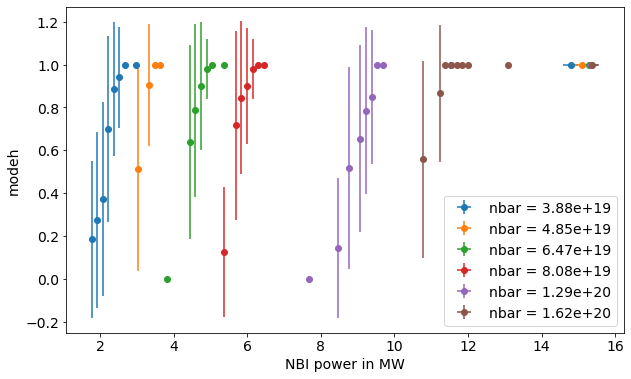

In [248]:
plt.figure(figsize=(10,6))

nbar = np.array([3.88303164e+19,4.85378955e+19,6.47171940e+19,
        8.08964925e+19,1.29434388e+20,1.61792985e+20])
labels = [3.88e19,4.85e19,6.47e19,8.08e19,1.29e20,1.62e20]
for i in range(len(nbar)):
    plt.errorbar(np.array(LH2_nbi[i])[:,0]*1e-6,np.array(LH2_modeh[i])[:,0],
                 np.array(LH2_modeh[i])[:,1],np.array(LH2_nbi[i])[:,1]*1e-6,
                 fmt='o',label="nbar = "+str(labels[i]))
plt.xlabel("NBI power in MW")
plt.ylabel("modeh")
plt.legend(loc="best")
plt.savefig("plots/PLHvsNBARMethod.pdf")
plt.show()

In [74]:
LH2s = np.zeros((6,2))
for i in range(6):
    LH2s[i] = findLH(np.array(LH2_nbi[i]),np.array(LH2_modeh[i]))

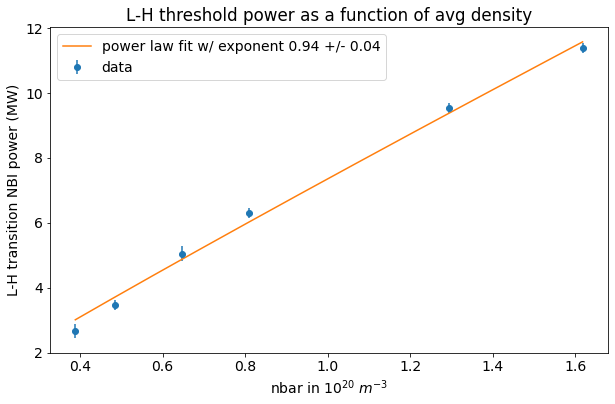

In [251]:
plt.figure(figsize=(10,6))
plt.errorbar(nbar*1e-20,LH2s[:,0]*1e-6,LH2s[:,1]*1e-6,fmt='o',label="data")

popt,cov = curve_fit(powerLaw,nbar*1e-20,LH2s[:,0]*1e-6,sigma=LH2s[:,1]*1e-6)
stds = np.sqrt(np.diag(cov))

x = np.linspace(min(nbar*1e-20),max(nbar*1e-20),1000)
plt.plot(x,powerLaw(x,popt[0],popt[1]),
         label="power law fit w/ exponent {:.2f} +/- {:.2f}".format(popt[1],stds[1]))

plt.xlabel(r"nbar in $10^{20}\;m^{-3}$")
plt.ylabel("L-H transition NBI power (MW)")
plt.legend(loc="best")
plt.title("L-H threshold power as a function of avg density")
plt.savefig("plots/PLHscalingNBAR.pdf")
plt.show()

**Comment:** Result show that $P_{LH} \propto \bar{n_e}^{0.94 \pm 0.04} \bar{B_t}^{0.98 \pm 0.07}$. The widely accepted empirical Martin's scaling from 2008 based on 1024 time slices (of which 562 stem from JET) [1, p. 3] which states that $P_{LH} \propto \bar{n_e}^{0.717 \pm 0.035} \bar{B_t}^{0.803 \pm 0.032}$. We not that the exponent intervals do not overlap, however a scaling exponent close to but below unity is captured here as well. <br>
In general this scaling of course means that increasing the density for higher fusion reaction rate as well as increasing the toroidal magnetic field for higher pressure at constant beta and therefore higher fusion reaction (if T constant) both requires a higher initial power threshold that the heating system must deliver to even enter H-mode in the first place.

[1] Y R Martin et al 2008 J. Phys.: Conf. Ser. 123 012033, https://doi.org/10.1088/1742-6596/123/1/012033 

## 3.3 Safety factor Q
### 3.3.1 Q vs Ip

In [76]:
from helpers import plot2axis2

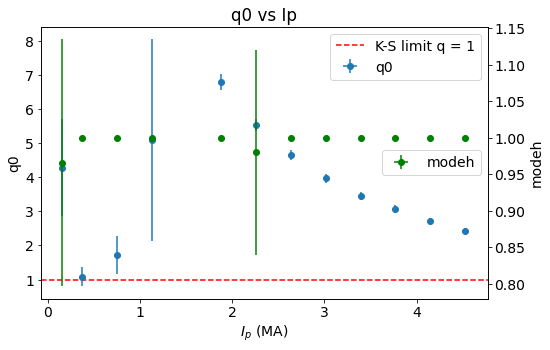

In [77]:
plt.axhline(y=1, color='r', linestyle='--',label="K-S limit q = 1")
plot2axis2(Ip_exp_q0,r"q0",
          Ip_exp_Ip*1e-6,r"$I_p$ (MA)",Ip_exp_modeh,"modeh",
          "q0 vs Ip",legend1="upper right")
plt.show()

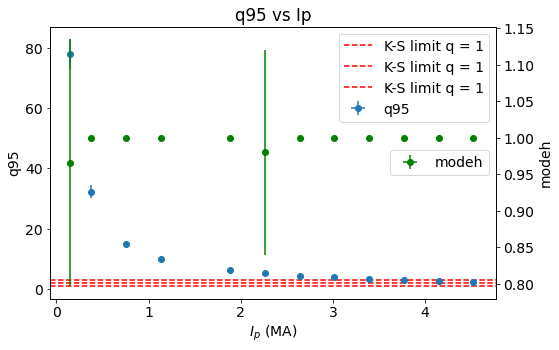

In [171]:
plt.axhline(y=1, color='r', linestyle='--',label="K-S limit q = 1")
plt.axhline(y=2, color='r', linestyle='--',label="K-S limit q = 1")
plt.axhline(y=3, color='r', linestyle='--',label="K-S limit q = 1")
plot2axis2(Ip_exp_q95,r"q95",
          Ip_exp_Ip*1e-6,r"$I_p$ (MA)",Ip_exp_modeh,"modeh",
          "q95 vs Ip",legend1="upper right")

plt.show()

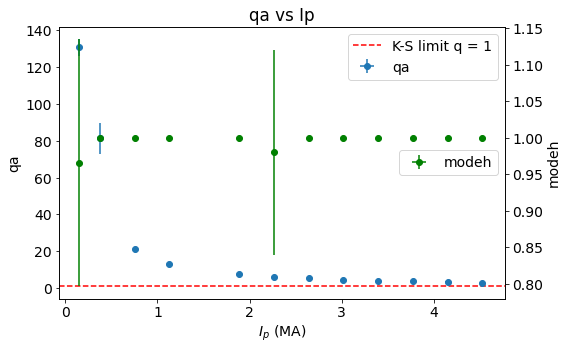

In [79]:
plt.axhline(y=1, color='r', linestyle='--',label="K-S limit q = 1")
plot2axis2(Ip_exp_qa,r"qa",
          Ip_exp_Ip*1e-6,r"$I_p$ (MA)",Ip_exp_modeh,"modeh",
          "qa vs Ip",legend1="upper right")
plt.show()

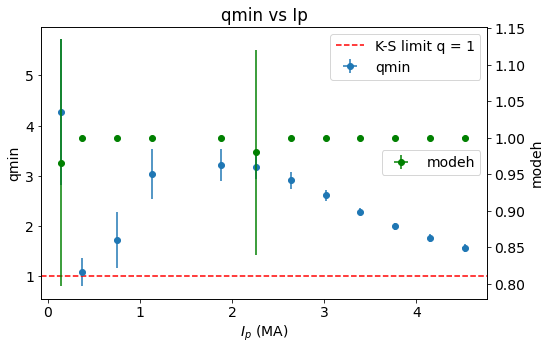

In [253]:
plt.axhline(y=1, color='r', linestyle='--',label="K-S limit q = 1")
plot2axis2(Ip_exp_qmin,r"qmin",
          Ip_exp_Ip*1e-6,r"$I_p$ (MA)",Ip_exp_modeh,"modeh",
          "qmin vs Ip",legend1="upper right")
plt.savefig("plots/qmin_Ip.pdf")
plt.show()

In [269]:
#minimum of qmin
min(Ip_exp_qmin[:,0])

1.0897581965867627

### 3.3.2 Q vs Bt

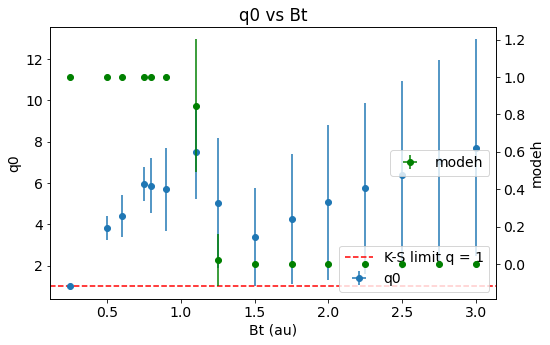

In [81]:
plt.axhline(y=1, color='r', linestyle='--',label="K-S limit q = 1")
plot2axis2(B0_exp_q0,r"q0",
          B0_exp_B0,r"Bt (au)",B0_exp_modeh,"modeh",
          "q0 vs Bt",legend1="lower right")
plt.show()

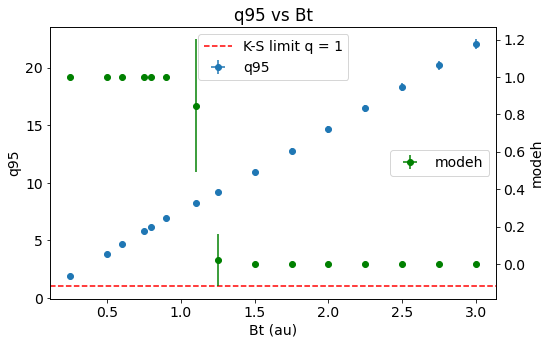

In [82]:
plt.axhline(y=1, color='r', linestyle='--',label="K-S limit q = 1")
plot2axis2(B0_exp_q95,r"q95",
          B0_exp_B0,r"Bt (au)",B0_exp_modeh,"modeh",
          "q95 vs Bt",legend1="upper center")
plt.show()

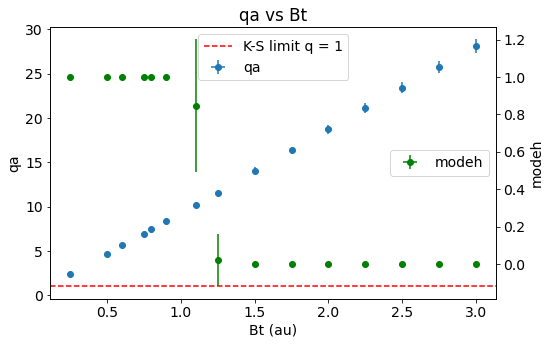

In [83]:
plt.axhline(y=1, color='r', linestyle='--',label="K-S limit q = 1")
plot2axis2(B0_exp_qa,r"qa",
          B0_exp_B0,r"Bt (au)",B0_exp_modeh,"modeh",
          "qa vs Bt",legend1="upper center")
plt.show()

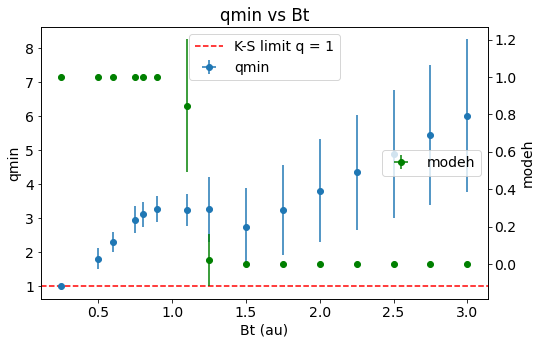

In [254]:
plt.axhline(y=1, color='r', linestyle='--',label="K-S limit q = 1")
plot2axis2(B0_exp_qmin,r"qmin",
          B0_exp_B0,r"Bt (au)",B0_exp_modeh,"modeh",
          "qmin vs Bt",legend1="upper center")
plt.savefig("plots/qmin_Bt.pdf")
plt.show()

In [268]:
#minimum of qmin
min(B0_exp_qmin[:,0])

1.0133461615252106

# 4 Power ramp experiments

In [85]:
ramp_steps = [1,2,3,4]

ramp_exp_nbi = [np.zeros((65)),np.zeros((130)),np.zeros((195)),np.zeros((260))]
ramp_exp_taue = [np.zeros((65)),np.zeros((130)),np.zeros((195)),np.zeros((260))]

for i in range(len(ramp_steps)):
    for j in range(ramp_steps[i]):
        data = scipy.io.loadmat("data/powerRamp/ramp"+str(i+1)+"/"+str(j)+".mat")
        ramp_exp_nbi[i][j*65:(j+1)*65] = get_variable_pnbi(data)[40:105] #cut2 cf. beginning of notebook
        ramp_exp_taue[i][j*65:(j+1)*65] = get_variable(data,'taue')[40:105] #cut2 cf. beginning of notebook

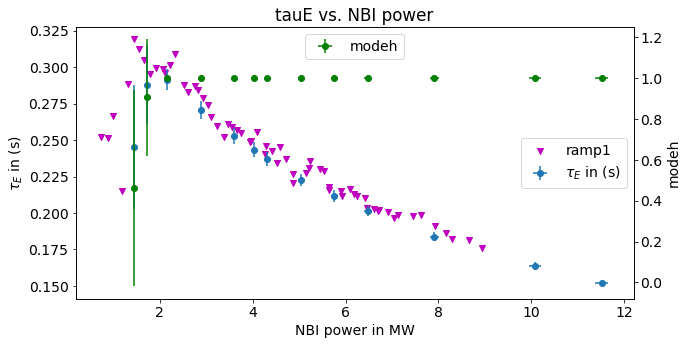

In [295]:
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'font.size': 14})

plt.scatter(ramp_exp_nbi[0]*1e-6,ramp_exp_taue[0],label="ramp1",
            linestyle="None",marker="v",color="m")

plot2axis2(nbi_exp_tauE[0:13],r"$\tau_E$ in (s)",nbi_exp_nbi[0:13]*1e-6,
          "NBI power in MW",nbi_exp_modeh[0:13],"modeh","tauE vs. NBI power",
           legend1="center right",legend2="upper center")
plt.savefig("plots/ramp1.pdf")
plt.show()

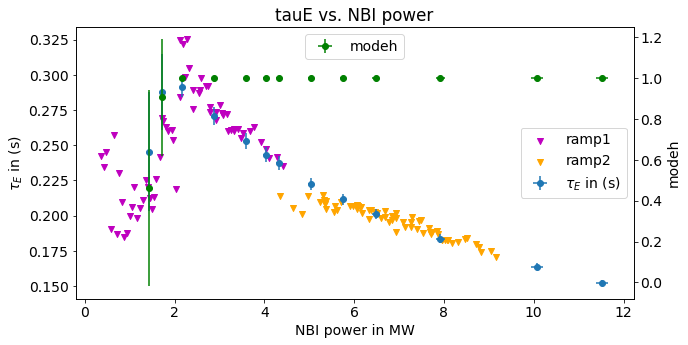

In [296]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(ramp_exp_nbi[1][0:65]*1e-6,ramp_exp_taue[1][0:65],label="ramp1",
            linestyle="None",marker="v",color="m")
plt.scatter(ramp_exp_nbi[1][65:130]*1e-6,ramp_exp_taue[1][65:130],label="ramp2",
            linestyle="None",marker="v",color="orange")

plot2axis2(nbi_exp_tauE[0:13],r"$\tau_E$ in (s)",nbi_exp_nbi[0:13]*1e-6,
          "NBI power in MW",nbi_exp_modeh[0:13],"modeh","tauE vs. NBI power",
           legend1="center right",legend2="upper center")
plt.savefig("plots/ramp2.pdf")
plt.show()

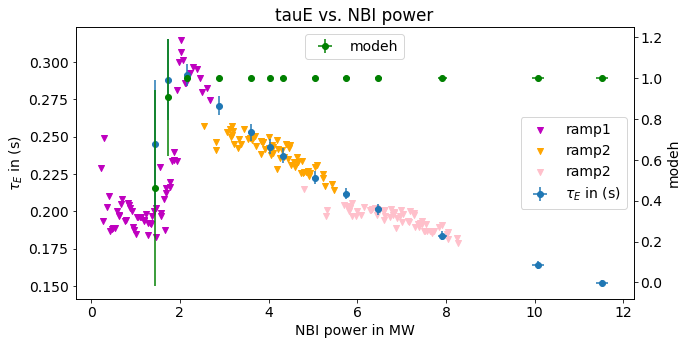

In [297]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(ramp_exp_nbi[2][0:65]*1e-6,ramp_exp_taue[2][0:65],label="ramp1",
            linestyle="None",marker="v",color="m")
plt.scatter(ramp_exp_nbi[2][65:130]*1e-6,ramp_exp_taue[2][65:130],label="ramp2",
            linestyle="None",marker="v",color="orange")
plt.scatter(ramp_exp_nbi[2][130:195]*1e-6,ramp_exp_taue[2][130:195],label="ramp2",
            linestyle="None",marker="v",color="pink")

plot2axis2(nbi_exp_tauE[0:13],r"$\tau_E$ in (s)",nbi_exp_nbi[0:13]*1e-6,
          "NBI power in MW",nbi_exp_modeh[0:13],"modeh","tauE vs. NBI power",
           legend1="center right",legend2="upper center")
plt.savefig("plots/ramp3.pdf")
plt.show()

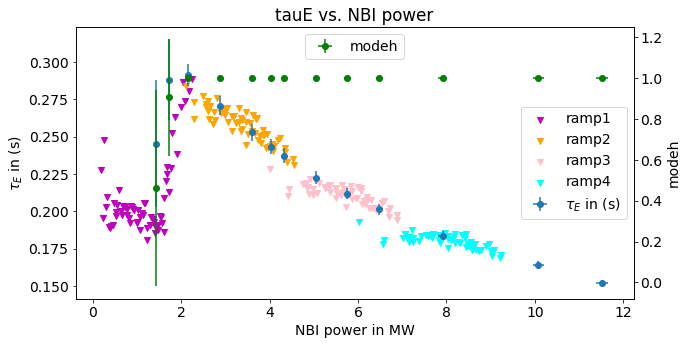

In [298]:
plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(ramp_exp_nbi[3][0:65]*1e-6,ramp_exp_taue[3][0:65],label="ramp1",
            linestyle="None",marker="v",color="m")
plt.scatter(ramp_exp_nbi[3][65:130]*1e-6,ramp_exp_taue[3][65:130],label="ramp2",
            linestyle="None",marker="v",color="orange")
plt.scatter(ramp_exp_nbi[3][130:195]*1e-6,ramp_exp_taue[3][130:195],label="ramp3",
            linestyle="None",marker="v",color="pink")
plt.scatter(ramp_exp_nbi[3][195:260]*1e-6,ramp_exp_taue[3][195:260],label="ramp4",
            linestyle="None",marker="v",color="cyan")

plot2axis2(nbi_exp_tauE[0:13],r"$\tau_E$ in (s)",nbi_exp_nbi[0:13]*1e-6,
          "NBI power in MW",nbi_exp_modeh[0:13],"modeh","tauE vs. NBI power",
           legend1="center right",legend2="upper center")
plt.savefig("plots/ramp4.pdf")
plt.show()

#### test agressively fast power ramp

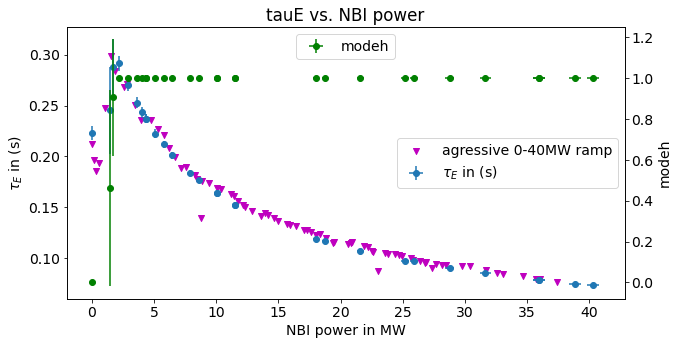

In [299]:
data = scipy.io.loadmat("data/powerRamp/ramp5/test0to40MWrampNBI.mat")
ramp5_exp_nbi = get_variable_pnbi(data)[32:110] #actual pnbi != 0 limits by manual test
ramp5_exp_taue = get_variable(data,'taue')[32:110]

plt.rcParams["figure.figsize"] = (10,5)
plt.scatter(np.array(ramp5_exp_nbi)*1e-6,ramp5_exp_taue,label="agressive 0-40MW ramp",
            linestyle="None",marker="v",color="m")

plot2axis2(nbi_exp_tauE,r"$\tau_E$ in (s)",nbi_exp_nbi*1e-6,
          "NBI power in MW",nbi_exp_modeh,"modeh","tauE vs. NBI power",
           legend1="center right",legend2="upper center")
plt.savefig("plots/ramp5.pdf")
plt.show()

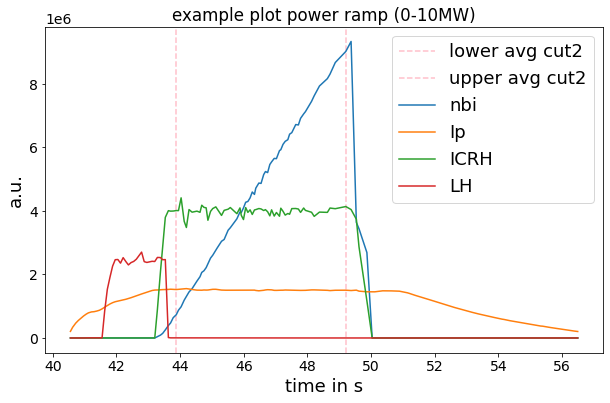

In [284]:
plt.figure(figsize=(10,6))
dataE = scipy.io.loadmat("data/powerRamp/ramp1/0.mat")
timeE = get_variable(dataE,'temps')
nbiE = get_variable_pnbi(dataE)
IpE = get_variable(dataE,'ip')
picrhE = get_variable(dataE,'picrh')
plhE = get_variable(dataE,'plh')

plt.axvline(x=timei[cut2[0]],color="pink",ls="--",label="lower avg cut2")
plt.axvline(x=timei[cut2[1]],color="pink",ls="--",label="upper avg cut2")

plt.plot(timeE,nbiE,label="nbi")
plt.plot(timeE,IpE,label="Ip")
plt.plot(timeE,picrhE,label="ICRH")
plt.plot(timeE,plhE,label="LH")
plt.xlabel("time in s",fontsize=18)
plt.ylabel("a.u.",fontsize=18)
plt.title("example plot power ramp (0-10MW)")
plt.legend(fontsize=18)
plt.savefig("plots/rampExample.pdf")
plt.show()